ResNet을 활용한 하천 분류 모델입니다.
학습에 사용한 데이터는 용량이 큰 관계로 아래 링크에서 다운 받을 수 있습니다.
Data set 지정 과정에서 추가적인 경로 설정이 필요합니다.

https://drive.google.com/drive/folders/1y_1BVRh3jepwuMR72lgonqlZsiKJL4Wl?usp=sharing

In [ ]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as utils
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import time
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from torch.optim import lr_scheduler
from torchsummary import summary
import torchvision.datasets
from PIL import Image
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torchvision
from torchvision import transforms

In [2]:
def convcacul(in_chan,out_chan,padd,filter,stride,type):
    size_out = (in_chan + 2*padd - filter)/stride + 1
    size_in = (out_chan-1)*stride -2*padd + filter 
    if type == 'forward':
        return size_out
    elif type == 'back':
        return size_in

In [3]:
convcacul(in_chan = 0, out_chan=32, padd = 1, filter = 3, stride = 1, type = 'back')

32

In [4]:
device = torch.device('cuda')

In [5]:
trans = transforms.Compose([transforms.Resize((128,128)),transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
train_set = torchvision.datasets.ImageFolder(root ='augmentation_image', transform = trans )
train_loader = DataLoader(dataset = train_set, batch_size = 8, shuffle = True, num_workers=8)

In [6]:
len(train_set)

2137

In [7]:
train_data, val_data = torch.utils.data.random_split(train_set,[1800,337])
batch_size = 32

In [ ]:
cnt_0 = 0
cnt_1 = 0
cnt_2 = 0
cnt_3 = 0
cnt_4 = 0

for i in range(1800):
    if train_data[i][1] == 0:
        cnt_0+=1
    elif train_data[i][1] == 1:
        cnt_1+=1
    elif train_data[i][1] == 2:
        cnt_2+=1
    elif train_data[i][1] == 3:
        cnt_3+=1
    elif train_data[i][1] == 4:
        cnt_4+=1    
        
#print(sum(cnt_1,cnt_0,cnt_2,cnt_3,cnt_4))
print(cnt_0,cnt_1,cnt_2,cnt_3,cnt_4)

weights = torch.tensor([cnt_0,cnt_1,cnt_2,cnt_3,cnt_4], dtype= torch.float32)
print(weights.sum())
weights = weights.sum()/weights
print(weights)
weights = weights/weights.sum()
print(weights)
print(weights.sum())

                       
class_weights = torch.FloatTensor(weights).cuda()

class_weights.size()


In [9]:
class_weights = torch.FloatTensor([0.2219, 0.1552, 0.1096, 0.1560, 0.3573]).cuda()

In [10]:
class ResidualBlock(nn.Module):
    def __init__(self,in_channels,out_channels,stride = 1, down_sample = False):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels,kernel_size =3, stride = stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.stride = stride
        
        if down_sample == True:
            self.down_sample = nn.Sequential(
                nn.Conv2d(in_channels = in_channels, out_channels= out_channels, kernel_size=1, stride= stride),
                nn.BatchNorm2d(num_features= out_channels)
            )
        else:
            self.down_sample= None
    
    def forward(self,x):
        shortcut = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)

        if self.down_sample is not None:
            shortcut = self.down_sample(shortcut)

        x += shortcut
        x = self.relu(x)
        return x

        

In [11]:
class ResNet(nn.Module):
    
    def __init__(self, num_layers, block, num_classes=5):
        super().__init__()
        # input img : [3, 128, 128]
        self.num_layers = num_layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16,
                               kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)

        # feature map size = [16,32,32] 16 128 128
        self.layers_2n = self.get_layers(block, 16, 16, stride=1)
        # feature map size = [32,16,16] 32 64 64
        self.layers_4n = self.get_layers(block, 16, 32, stride=2)
        # feature map size = [64,8,8]  64 32 32
        self.layers_6n = self.get_layers(block, 32, 64, stride=2)
        # feature map size = [64,8,8]  128 16 16
        self.layers_8n = self.get_layers(block, 64, 128, stride=2)
        # feature map size = [64,8,8]  256 8 8
        self.layers_10n = self.get_layers(block, 128, 256, stride=2)
####################################################################################################################################
        # output layers
        self.pool = nn.AvgPool2d(8, stride=1)
        # fearute map size = [256,1,1]
        self.fc_out = nn.Linear(256, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def get_layers(self, block, in_channels, out_channels, stride):
        if stride == 2:
            down_sample = True
        else:
            down_sample = False

        layers_list = nn.ModuleList([block(in_channels, out_channels, stride, down_sample)])

        for _ in range(self.num_layers - 1):
            layers_list.append(block(out_channels, out_channels))

        return nn.Sequential(*layers_list)

        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.layers_2n(x)
        x = self.layers_4n(x)
        x = self.layers_6n(x)
        x = self.layers_8n(x)
        x = self.layers_10n(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc_out(x)
        return x

def ResNet34_model():
    block = ResidualBlock
    model = ResNet(num_layers=5, block=block)
    return model


In [12]:
train_batch_loader = DataLoader(train_data, batch_size, shuffle=True)
val_batch_loader = DataLoader(val_data, batch_size, shuffle=False)
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [13]:
model = ResNet34_model()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [14]:
start_time = time.time()
highest_val_acc = 0
loss_list = []
val_acc_list = []
global_steps = 0
epoch = 0

print('========================================')
print("Start training...")
while True:
    train_loss = 0
    train_batch_cnt = 0
    model.train()
    for img, label in train_batch_loader:
        global_steps += 1
        # img.shape: [128,3,32,32]
        # label.shape: [128]
        img = img.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        outputs = model(img)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()
        train_loss += loss
        train_batch_cnt += 1

        loss_list.append(loss)        

        if global_steps >= 15000:
            print("Training finished.")
            break
        elif epoch > 20:
            break
        

    ave_loss = train_loss / train_batch_cnt
    ave_loss_list = []
    ave_loss_list.append(ave_loss)
    training_time = (time.time() - start_time) / 60
    print('========================================')
    print("epoch:", epoch + 1, "/ global_steps:", global_steps)
    print("training dataset average loss: %.3f" % ave_loss)
    print("training_time: %.2f minutes" % training_time)

    # validation (for early stopping)
    correct_cnt = 0
    model.eval()
    for img, label in val_batch_loader:
        img = img.to(device)
        label = label.to(device)
        pred = model.forward(img)
        _, top_pred = torch.topk(pred, k=1, dim=-1)
        top_pred = top_pred.squeeze(dim=1)
        correct_cnt += int(torch.sum(top_pred == label))

    val_acc = correct_cnt / len(val_data) * 100
    print("validation dataset accuracy: %.2f" % val_acc)
    print(top_pred-label)
    print('validation my accuracy:',abs(label - top_pred).sum()/len(label))
    val_acc_list.append(val_acc)
    if val_acc > highest_val_acc:
        save_path = './' + str(epoch + 1) + '.pth'
        # 위와 같이 저장 위치를 바꾸어 가며 각 setting의 epoch마다의 state를 저장할 것.
        torch.save({'epoch': epoch + 1,
                    'model_state_dict': model.state_dict()},
                    save_path)
        highest_val_acc = val_acc
    epoch += 1
    if global_steps >= 15000:
        break
    elif epoch > 20:
        break

Start training...
epoch: 1 / global_steps: 57
training dataset average loss: 1.410
training_time: 0.95 minutes
validation dataset accuracy: 41.54
tensor([-1,  0,  0,  1,  2,  0,  1,  0,  2,  0,  1,  0,  2,  3,  1,  0,  0],
       device='cuda:0')
validation my accuracy: tensor(0.8235, device='cuda:0')
epoch: 2 / global_steps: 114
training dataset average loss: 1.060
training_time: 1.96 minutes
validation dataset accuracy: 45.70
tensor([ 0, -2,  0,  1, -1,  0, -1, -2,  0, -3,  0,  0,  0,  2,  0,  0, -1],
       device='cuda:0')
validation my accuracy: tensor(0.7647, device='cuda:0')
epoch: 3 / global_steps: 171
training dataset average loss: 0.966
training_time: 3.00 minutes
validation dataset accuracy: 38.28
tensor([ 0, -2,  0,  0,  1, -2, -1,  1,  0,  0,  2,  0,  3,  0, -1,  0,  1],
       device='cuda:0')
validation my accuracy: tensor(0.8235, device='cuda:0')
epoch: 4 / global_steps: 228
training dataset average loss: 0.937
training_time: 4.05 minutes
validation dataset accuracy: 40

In [18]:
trans_test = transforms.Compose([transforms.Resize((128,128)),transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
test_data = torchvision.datasets.ImageFolder(root ='HRI_image', transform = trans_test )
test_batch_loader = DataLoader(test_data, batch_size, shuffle=False)

model.eval()
checkpoint = torch.load(save_path)
model.load_state_dict(checkpoint['model_state_dict'])
epoch = checkpoint['epoch']
correct_cnt = 0
with torch.no_grad():
  for img, label in test_batch_loader:
    img = img.to(device)
    label = label.to(device)
    pred = model.forward(img)
    _, top_pred = torch.topk(pred, k=1, dim=-1)
    top_pred = top_pred.squeeze(dim=1)
    correct_cnt += int(torch.sum(top_pred == label))
    
test_acc = correct_cnt / len(test_data) * 100
print("test data accuracy : %.2f"%(test_acc))

test data accuracy : 77.09


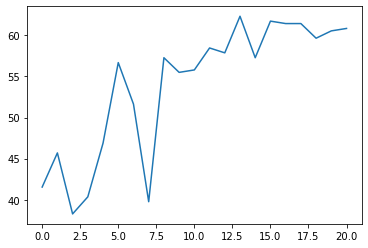

In [21]:
#plt.plot(ave_loss_list)
#plt.show()
plt.plot(val_acc_list)
plt.show()

In [20]:
ave_loss_list

[tensor(0.1820, device='cuda:0', grad_fn=<DivBackward0>)]

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()